ここまでの説明で、Python の基本的な使い方は学べたと思います。ここからは、いよいよ OpenCV を使って行きます。まず、OpenCV が動くことを確認しましょう。

In [ ]:
import cv2
print(cv2.__version__)

4.7.0


次に、画像ファイルを取得します。下記のコードはhttps://colab.research.google.com/github/computationalcore/introduction-to-opencv/blob/master/notebooks/1-Fundamentals.ipynb から拝借したものですが、https: に続くURLを変更すれば好きな画像をダウンロード可能です。

In [ ]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/computationalcore/introduction-to-opencv/master/assets/noidea.jpg \
    -O noidea.jpg

--2023-07-10 04:35:47--  https://raw.githubusercontent.com/computationalcore/introduction-to-opencv/master/assets/noidea.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70503 (69K) [image/jpeg]
Saving to: ‘noidea.jpg’

noidea.jpg          100%[===================>]  68.85K  --.-KB/s    in 0.001s  

2023-07-10 04:35:47 (48.7 MB/s) - ‘noidea.jpg’ saved [70503/70503]



画像の表示に matplotlib を用いるので、import しておきます。

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt

これで、画像を表示する準備ができました。早速、OpenCV で読み込んで、描画を行いましょう。

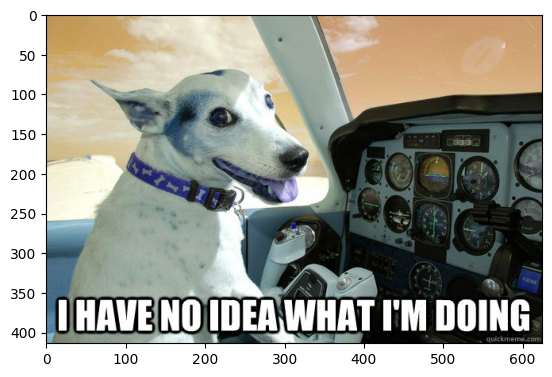

In [ ]:
img=cv2.imread('noidea.jpg')
plt.imshow(img)

画像が無事に表示できたはずです。C++ 版とほぼ同じ関数が Python 版でも使えますが、若干引数等々が異なることがあるので、調べながら試して下さい。

画像の読み込みができたので、OpenCV の機能を試してみましょう。

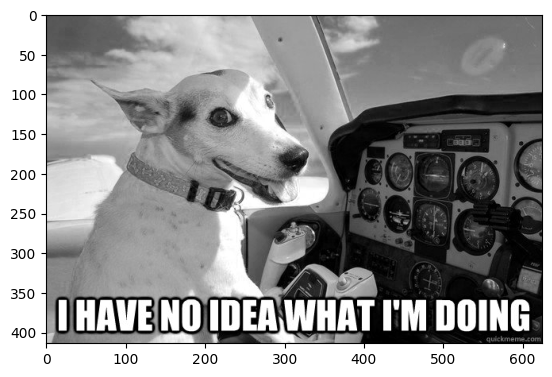

In [ ]:
b,g,r=cv2.split(img)
plt.imshow(r,cmap='gray')

このコードでは、b,g,r の3つのカラーチャネルに画像を分解し、そのうち r チャネルのみを描画しています。cmap='gray' というのは、単一のチャネルを描画するためのおまじないです。真面目に grayscale 画像を出力する場合には、次のようにします。

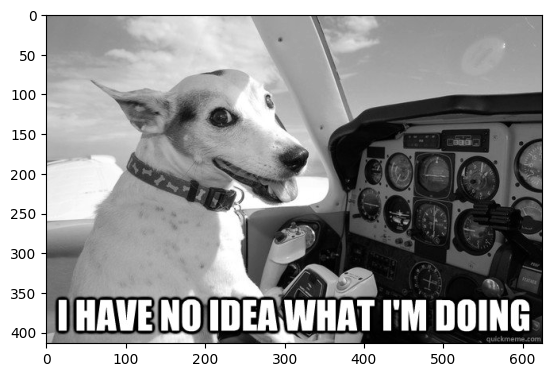

In [ ]:
gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
plt.imshow(gray,cmap='gray')

では、次に、Python OpenCV で画素値を直接扱っていましょう。C++ 版では Mat という形式でデータが保持されていましたが、Python 版では ndarray という NumPy ライブラリにおいて実装されている形式で画像が保存されています。以下の操作によって、どのような表現になっているかが理解できるでしょう。

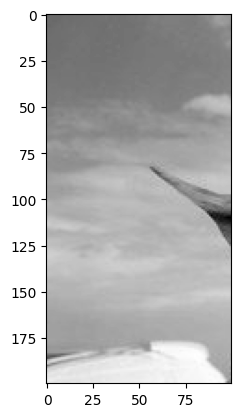

In [ ]:
plt.imshow(gray[0:200,0:100],cmap='gray')

grayscale 画像は1チャネルなので、2次元の座標が指定されれば直ちに値が決定されます。最初のインデックスが縦方向の、2つめのインデックスが横方向の位置を表しています。次に、カラーで試してみましょう。

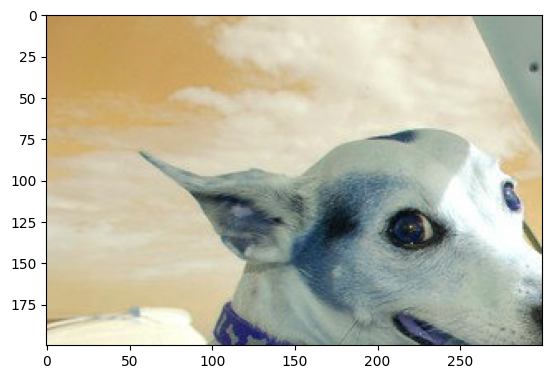

In [ ]:
plt.imshow(img[0:200,0:300,:])

3つめのインデックスはカラーチャネルを表しており、スライス : によって、全てのチャネルを切り出しています。カラーチャネルは、0 番目が b 、1 番目が g 、2番目が r になっています。アルファチャネル付きだと BGRA の並びになり、3番目が A となります。従って、以下でも bgr を取り出せます。

In [ ]:
b=img[:,:,0]
g=img[:,:,1]
r=img[:,:,2]

ここでは、最初の2つのインデックスに対してスライス操作を行っており、最後の0,1,2でカラーチャネルを取り出しています。RGB 空間から YUV 空間への変換のうち、grayscale 画像の生成に必要な Y の演算は Y = 0.299xR+0.587xG+0.114xB で求められるので、次の計算で grayscale 画像を画素単位の計算によって求められます。

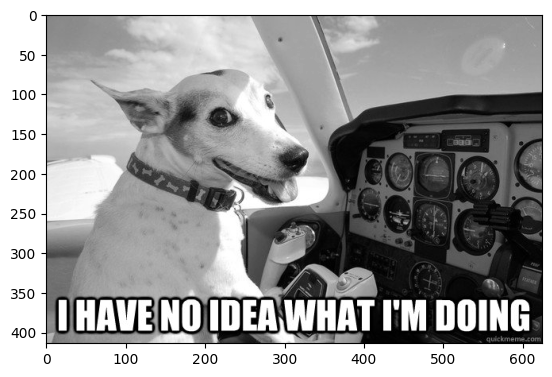

In [ ]:
gray2=0.299*r+0.587*g+0.114*b
plt.imshow(gray2,cmap='gray')

OpenCV の関数を叩く練習として、gray scale 画像を入力とした空間フィルタををやってみましょう。使うメソッドは filter2D です。filter2D ではフィルタ係数に ndarray 型の変数が必要となります。次のコードで値の設定方法を見てみましょう。

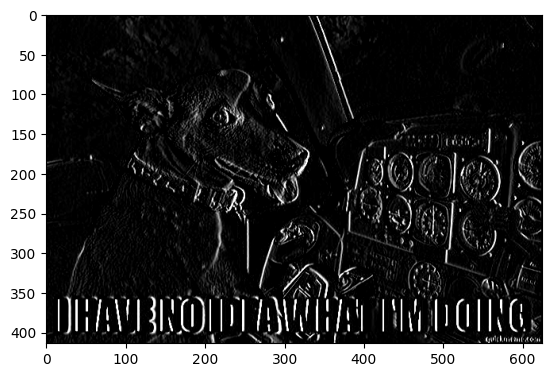

In [ ]:
import numpy as np
kernel=np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
result=cv2.filter2D(gray,-1,kernel)
plt.imshow(result,cmap='gray')

このように、簡単に OpenCV を用いた画像処理の実行が可能です。詳しくは、適切なキーワードで検索を行って下さい。

さて、Python 版の OpenCV だと、C++ 版よりもさらに容易にコードを記述できることが分かると思います。そこで、より複雑なアプリケーションの動作に挑戦してみましょう。ここでは、YOLO と呼ばれる深層学習に基づく物体検出手法を動作させてみます。まず、次のファイルをダウンロードしましょう。

In [ ]:
!wget --no-check-certificate \
https://pjreddie.com/media/files/yolov3.weights \
https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg \
https://raw.githubusercontent.com/arunponnusamy/object-detection-opencv/master/yolov3.txt

--2023-07-10 04:42:50--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  45.9MB/s    in 5.5s    

2023-07-10 04:42:56 (42.9 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]

--2023-07-10 04:42:56--  https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8342 (8.1K) [text/plain]
Saving to: ‘yolov3.cfg’

yolov3.cfg          100%[===================>]   8.15K  --.-KB/s    in 0s      


これらのファイルは学習済みの重みファイル、yolo を動作させるための設定ファイル、yolo が検出できるクラス名のリストになります。

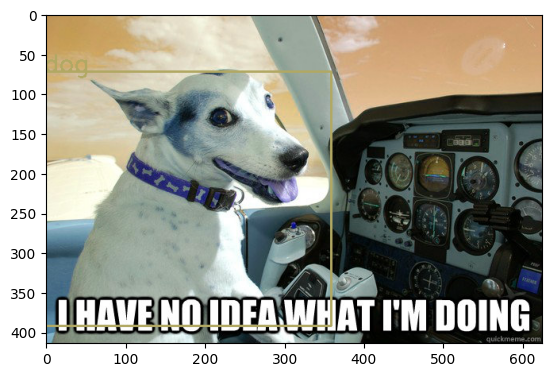

In [ ]:
def get_output_layers(net):
  layer_names = net.getLayerNames()
  output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]
  return output_layers

def draw_bbox(img, class_id, confidence, x, y, w, h):
  label=str(classes[class_id])
  color=COLORS[class_id]
  cv2.rectangle(img, (x,y), (w,h), color, 2)
  cv2.putText(img, label, (x,y), cv2.FONT_HERSHEY_SIMPLEX, 1.0, color, 2)

with open('yolov3.txt', 'r') as f:
  classes = [line.strip() for line in f.readlines()]
COLORS = np.random.uniform(0, 255, size=(len(classes), 3))

img=cv2.imread('noidea.jpg')
net=cv2.dnn.readNet('yolov3.cfg', 'yolov3.weights')
blob=cv2.dnn.blobFromImage(img, 1/255.0, (416, 416), swapRB=True, crop=False)
net.setInput(blob)
outs=net.forward(get_output_layers(net))

class_ids=[]
confidences=[]
boxes=[]
conf_threshold=0.7
nms_threshold=0.4
Width=img.shape[1]
Height=img.shape[0]

for out in outs:
  for detection in out:
    scores = detection[5:]
    class_id = np.argmax(scores)
    confidence = scores[class_id]
    if confidence > 0.5:
      center_x = int(detection[0] * Width)
      center_y = int(detection[1] * Height)
      w = int(detection[2] * Width)
      h = int(detection[3] * Height)
      x = center_x - w / 2
      y = center_y - h / 2
      class_ids.append(class_id)
      confidences.append(float(confidence))
      boxes.append([x, y, w, h])

indices = cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold, nms_threshold)
for i in indices:
  box = boxes[i]
  x = box[0]
  y = box[1]
  w = box[2]
  h = box[3]

  draw_bbox(img, class_ids[i], confidences[i], round(x), round(y), round(x+w), round(y+h))

plt.imshow(img)

最後に、カメラを使ってみましょう。Cobal の画面の左下にある <> をクリックし、Camera Catpure をクリックし、挿入を押せば下記のコードが入力されます。

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


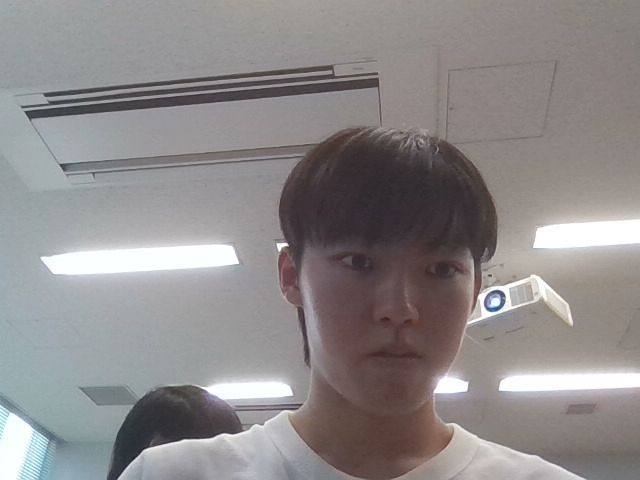

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

imread で読み込んで、matplotlib で表示するには、以下のようにすれば良いでしょう。

<IPython.core.display.Javascript object>

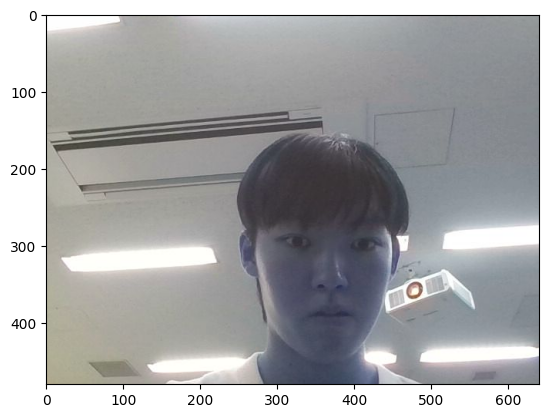

In [ ]:
try:
  filename=take_photo()
  img=cv2.imread(filename)
  plt.imshow(img)
except Exception as err:
  print(str(err))

#必須課題1

In [10]:
import re

l=[]
l_int=[]
L=[]
p=re.compile('(\d+)(,|\n)')
p1=re.compile('(\d+)')

with open('filter.txt') as f:
  list=f.readlines()

  for line in list:
    while True:
      if p.match(line):
        l.append(line[p.match(line).start():p.match(line).end()-1])
        line=line[p.match(line).end():]
      else:
        if l!=[]:
          l_int=[int(s) for s in l]
          L.append(l_int)
          l=[]
        break

  print(L)


[[1, 0, 1], [0, 0, 0], [0, 1, 0]]


#必須課題2

[[1, 0, 1], [0, 0, 0], [0, 1, 0]]
--2023-07-12 05:02:43--  https://raw.githubusercontent.com/computationalcore/introduction-to-opencv/master/assets/noidea.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70503 (69K) [image/jpeg]
Saving to: ‘noidea.jpg’

noidea.jpg          100%[===================>]  68.85K  --.-KB/s    in 0.01s   

2023-07-12 05:02:43 (4.49 MB/s) - ‘noidea.jpg’ saved [70503/70503]



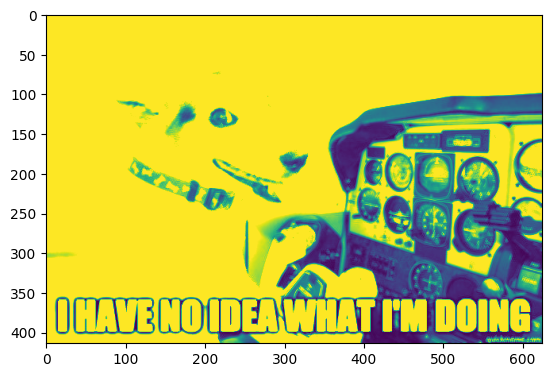

In [ ]:
import re
import cv2
import numpy as np

l=[]
l_int=[]
L=[]
p=re.compile('((-|\d)+)(,|\n)')
p1=re.compile('(\d+)')

with open('filter.txt') as f:
  list=f.readlines()

  for line in list:
    while True:
      if p.match(line):
        l.append(line[p.match(line).start():p.match(line).end()-1])
        line=line[p.match(line).end():]
      else:
        if l!=[]:
          l_int=[int(s) for s in l]
          L.append(l_int)
          l=[]
        break

  print(L)

!wget --no-check-certificate \
    https://raw.githubusercontent.com/computationalcore/introduction-to-opencv/master/assets/noidea.jpg \
    -O noidea.jpg

%matplotlib inline
from matplotlib import pyplot as plt

img=cv2.imread('noidea.jpg')

gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

karnel=np.array(L,dtype=np.float32)

img_out=cv2.filter2D(src=gray, ddepth=-1, kernel=karnel)

plt.imshow(img_out)

#必須課題３

--2023-07-12 05:15:59--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights.5’

yolov3.weights.5    100%[===================>] 236.52M  39.2MB/s    in 6.4s    

2023-07-12 05:16:06 (36.8 MB/s) - ‘yolov3.weights.5’ saved [248007048/248007048]

--2023-07-12 05:16:06--  https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8342 (8.1K) [text/plain]
Saving to: ‘yolov3.cfg.5’

yolov3.cfg.5        100%[===================>]   8.15K  --.-KB/s    in 0s 

<IPython.core.display.Javascript object>

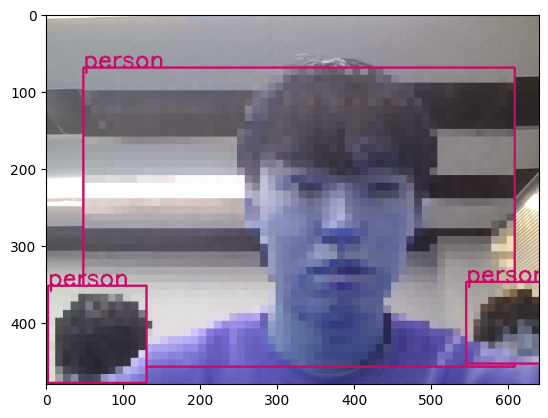

In [11]:
!wget --no-check-certificate \
https://pjreddie.com/media/files/yolov3.weights \
https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg \
https://raw.githubusercontent.com/arunponnusamy/object-detection-opencv/master/yolov3.txt

%matplotlib inline
from matplotlib import pyplot as plt

from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
import cv2
import numpy as np

person=True
dst_area=None

def mosaic(src, ratio=0.1):
    small = cv2.resize(src, None, fx=ratio, fy=ratio, interpolation=cv2.INTER_NEAREST)
    return cv2.resize(small, src.shape[:2][::-1], interpolation=cv2.INTER_NEAREST)

def mosaic_area(src, x, y, width, height, ratio=0.1):
    dst = src.copy()
    dst[y:y + height, x:x + width] = mosaic(dst[y:y + height, x:x + width], ratio)
    return dst

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

try:
  filename=take_photo()
  img=cv2.imread(filename)
  def get_output_layers(net):
    layer_names = net.getLayerNames()
    output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]
    return output_layers

  def draw_bbox(img, class_id, confidence, x, y, w, h):
    label=str(classes[class_id])
    color=COLORS[class_id]
    cv2.rectangle(img, (x,y), (w,h), color, 2)
    cv2.putText(img, label, (x,y), cv2.FONT_HERSHEY_SIMPLEX, 1.0, color, 2)

  with open('yolov3.txt', 'r') as f:
    classes = [line.strip() for line in f.readlines()]
  COLORS = np.random.uniform(0, 255, size=(len(classes), 3))

  net=cv2.dnn.readNet('yolov3.cfg', 'yolov3.weights')
  blob=cv2.dnn.blobFromImage(img, 1/255.0, (416, 416), swapRB=False, crop=False)
  net.setInput(blob)
  outs=net.forward(get_output_layers(net))

  class_ids=[]
  confidences=[]
  boxes=[]
  conf_threshold=0.7
  nms_threshold=0.4
  Width=img.shape[1]
  Height=img.shape[0]

  for out in outs:
    for detection in out:
      scores = detection[5:]
      class_id = np.argmax(scores)
      confidence = scores[class_id]
      if confidence > 0.5:
        center_x = int(detection[0] * Width)
        center_y = int(detection[1] * Height)
        w = int(detection[2] * Width)
        h = int(detection[3] * Height)
        x = center_x - w / 2
        y = center_y - h / 2
        class_ids.append(class_id)
        confidences.append(float(confidence))
        boxes.append([x, y, w, h])

  indices = cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold, nms_threshold)
  for i in indices:
    box = boxes[i]
    x = box[0]
    y = box[1]
    w = box[2]
    h = box[3]

    if class_ids[i]==0 and person:
      x_int=int(x)
      y_int=int(y)
      w_int=int(w)
      h_int=int(h)
      dst_area=mosaic_area(img,x_int,y_int,w_int,h_int)
      person=False
    elif class_ids[i]==0 and dst_area is not None:
      x_int=int(x)
      y_int=int(y)
      w_int=int(w)
      h_int=int(h)
      dst_area=mosaic_area(dst_area,x_int,y_int,w_int,h_int)

    draw_bbox(dst_area, class_ids[i], confidences[i], round(x), round(y), round(x+w), round(y+h))

  plt.imshow(dst_area)

except Exception as err:
  print(str(err))
